## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [0]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

> Блок с отступами



Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [0]:
# (re-)load layers
%run modules2.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

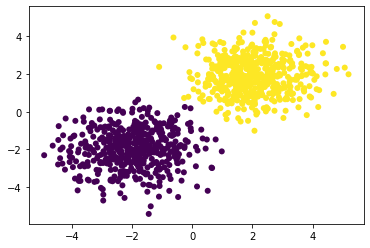

In [0]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [0]:
#net = Sequential()
#net.add(Linear(2, 2))
#net.add(LogSoftMax())

criterion = ClassNLLCriterion()

#print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [0]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-2, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 1000
batch_size = 100

In [0]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

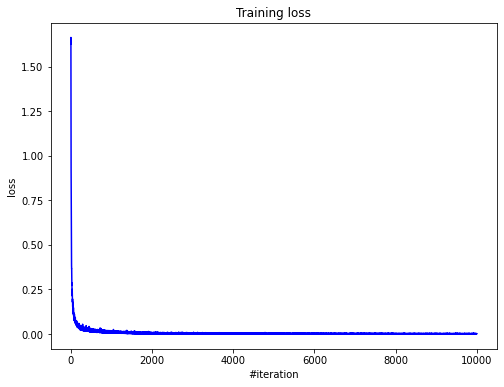

Current loss: 0.000555


In [0]:
loss_history = []
        
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)   


# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [0]:
import mnist
X_train, y_train_raw, X_val, y_val_raw, X_test, y_test_raw = mnist.load_dataset()

One-hot encode the labels first.

In [0]:
#Let's flatten X_train and other

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] * X_val.shape[2])

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [0]:
X_train.shape

num_features = 784

In [0]:
labels = np.unique(y_train_raw)

In [0]:
#Make one hot encoding
y_train = [y == labels for y in y_train_raw]
y_train = np.int64(np.array(y_train))

y_val = [y == labels for y in y_val_raw]
y_val = np.int64(np.array(y_val))

y_test = [y == labels for y in y_test_raw]
y_test = np.int64(np.array(y_test))

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [0]:
def train_sgd(net, loss_func, n_epoch, batch_size, optimizer_config,X_train, Y_train, graph_title):
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()

            pred = net.forward(x_batch)
            loss = loss_func.forward(pred, y_batch)
            dp = loss_func.backward(pred, y_batch)
            net.backward(x_batch, dp)

            sgd_momentum(net.getParameters(), 
                   net.getGradParameters(),
                   optimizer_config, {})
      
            loss_history.append(loss)
    
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))
        
            plt.title(graph_title)
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()
    
            print('Current loss: %f' % loss)    

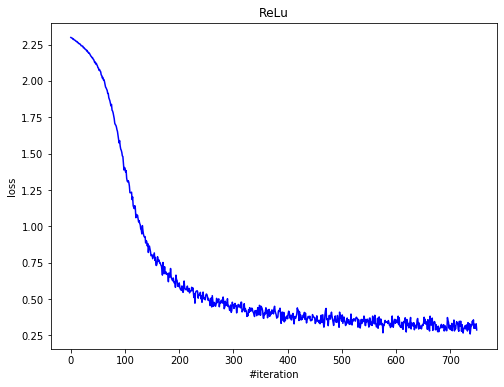

Current loss: 0.287329


In [0]:
#Let's build first model
optimizer_config['learning_rate'] = 5e-2
relu_net = Sequential()

relu_net.add(Linear(num_features,  num_features))

relu_net.add(ReLU())

relu_net.add(Linear(num_features, num_features))

relu_net.add(ReLU())

relu_net.add(Linear(num_features, 10))

relu_net.add(LogSoftMax())

train_sgd(relu_net, ClassNLLCriterion(), 15, 1000, optimizer_config,
         X_train=X_train, Y_train=y_train, graph_title="ReLu")


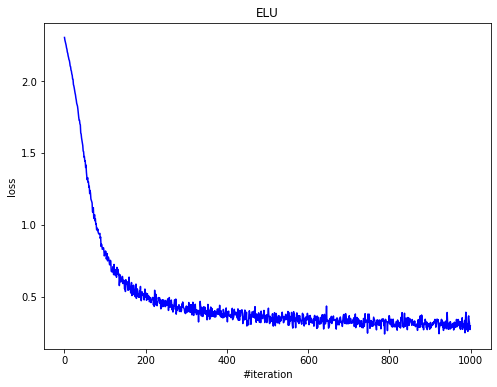

Current loss: 0.296349


In [0]:
#ELU
optimizer_config['learning_rate'] = 5e-2

elu_net = Sequential()
elu_net.add(Linear(num_features,  num_features))

elu_net.add(ELU())

elu_net.add(Linear(num_features, num_features))

elu_net.add(ELU())

elu_net.add(Linear(num_features, 10))
elu_net.add(LogSoftMax())

train_sgd(elu_net, ClassNLLCriterion(), 20, 1000, optimizer_config,
         X_train=X_train, Y_train=y_train, graph_title="ELU")




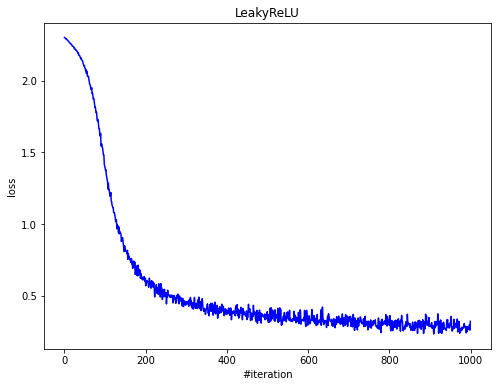

Current loss: 0.319968


In [0]:
optimizer_config['learning_rate'] = 5e-2

lrelu_net = Sequential()
lrelu_net.add(Linear(num_features,  num_features))

lrelu_net.add(LeakyReLU())

lrelu_net.add(Linear(num_features, num_features))

lrelu_net.add(LeakyReLU())

lrelu_net.add(Linear(num_features, 10))
lrelu_net.add(LogSoftMax())

train_sgd(lrelu_net, ClassNLLCriterion(), 20, 1000, optimizer_config,
         X_train=X_train, Y_train=y_train, graph_title="LeakyReLU")


In [0]:
optimizer_config['learning_rate'] = 5e-2

soft_plus_net = Sequential()
soft_plus_net.add(Linear(num_features, num_features))

soft_plus_net.add(SoftPlus())

soft_plus_net.add(Linear(num_features, num_features))

soft_plus_net.add(SoftPlus())

soft_plus_net.add(Linear(num_features, 10))

soft_plus_net.add(LogSoftMax())

train_sgd(soft_plus_net, ClassNLLCriterion(), 20, 1000, optimizer_config, X_train, y_train, "Soft Plus")



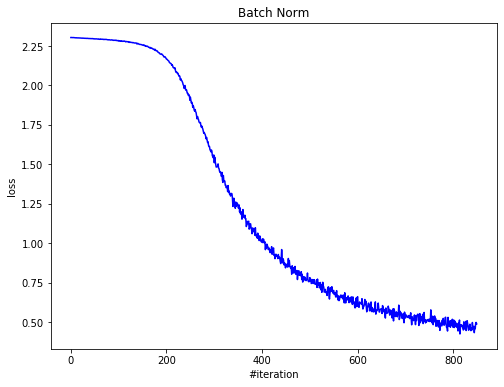

Current loss: 0.488422


In [0]:
#Now let's use BatchNorm layer

optimizer_config['learning_rate'] = 5e-2


bn_net = Sequential()
bn_net.add(Linear(num_features, num_features))

bn_net.add(ReLU())

bn_net.add(BatchNormalization(0.3))
bn_net.add(ChannelwiseScaling(num_features))

bn_net.add(Linear(num_features, num_features))

bn_net.add(BatchNormalization(0.3))
bn_net.add(ChannelwiseScaling(num_features))

bn_net.add(Linear(num_features, 10))

bn_net.add(LogSoftMax())

bn_net.training = True

train_sgd(bn_net, ClassNLLCriterion(), 25, 1500, optimizer_config, 
          X_train, y_train, "Batch Norm")


In [0]:
# ADAM

def train_adam(net, loss_func, n_epoch,
               batch_size, optimizer_config,
               X_train, Y_train,
               graph_title, state={}, gradient_clipping=5):
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X_train, Y_train), batch_size):
            net.zeroGradParameters()

            pred = net.forward(x_batch)
            loss = loss_func.forward(pred, y_batch)
            dp = loss_func.backward(pred, y_batch)
            net.backward(x_batch, dp)

            adam_optimizer(net.getParameters(), 
                   net.getGradParameters(),
                   optimizer_config, state, gradient_clipping=gradient_clipping)
      
            loss_history.append(loss)
    
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))
        
            plt.title(graph_title)
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()
            plt.savefig("plot.png")
            print('Current loss: %f' % loss)    



<Figure size 432x288 with 0 Axes>

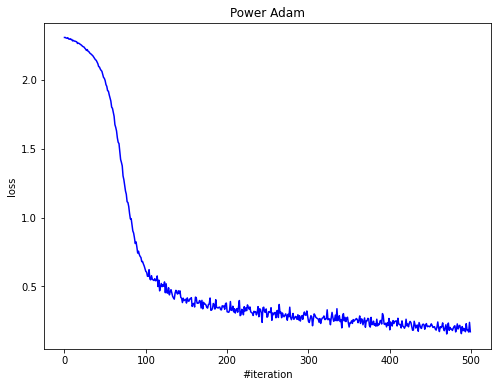

Current loss: 0.171633


<Figure size 432x288 with 0 Axes>

In [0]:
#Let's test it
adam_test = Sequential()

adam_test.add(Linear(num_features, num_features))
adam_test.add(ReLU())
adam_test.add(Linear(num_features, num_features))
adam_test.add(ReLU())
adam_test.add(Linear(num_features, 10))

adam_test.add(LogSoftMax())

state = {} #We use it just for storing gradients

adam_config = {'learning_rate':5e-2, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-1}
train_adam(adam_test, ClassNLLCriterion(), 10, 1000, 
           adam_config, X_train, y_train,
           "Power Adam", state, gradient_clipping=None)
#train_sgd(adam_test, ClassNLLCriterion(), 10, 1000, optimizer_config, X_train, y_train, "__")

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

Мы видим, что ReLU - лучший вариант для функции активации. Это намного быстрее для вычислений и для почти такой же точности.

Как мы видим на графике выше, BatchNorm снижает шум потерь, а это означает, что наша сеть стала более стабильной, так что да, это помогает.


**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [0]:
my_net = Sequential()

#First block
my_net.add(Linear(num_features, 2 * num_features))
my_net.add(ReLU())
my_net.add(BatchNormalization(alpha=0.9))
my_net.add(Dropout(0.5))

#Second block

my_net.add(Linear(num_features * 2, num_features * 2))
my_net.add(ReLU())
my_net.add(BatchNormalization(alpha=0.9))
my_net.add(Dropout(0.5))

#Third block

my_net.add(Linear(num_features * 2, num_features * 2))
my_net.add(ReLU())
my_net.add(BatchNormalization(alpha=0.9))
my_net.add(Dropout(0.5))

#Output

my_net.add(Linear(num_features * 2, 10))
my_net.add(LogSoftMax())


<Figure size 432x288 with 0 Axes>

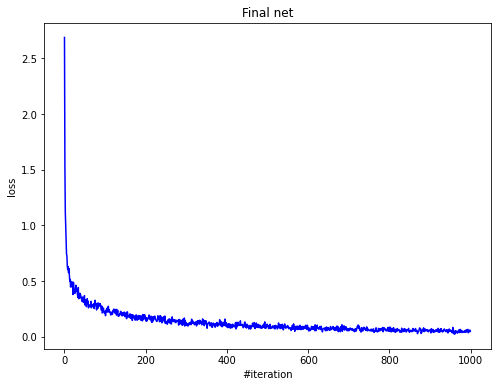

Current loss: 0.048440


<Figure size 432x288 with 0 Axes>

In [63]:
#Train

adam_config = {'learning_rate':5e-2, 'beta1':0.9, 'beta2':0.999, 'epsilon':1e-1}
state = {}
my_net.train()

train_adam(my_net, ClassNLLCriterion(), 20, 1000,
           adam_config, X_train, y_train,
           "Final net", state)



Print here your accuracy on test set. It should be around 90%.

In [64]:
# Your answer goes here. ################################################
my_net.evaluate()

from sklearn.metrics import accuracy_score

accuracy_score(y_test_raw, np.argmax(my_net.forward(X_test), axis=1))


0.9811

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [105]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

y_train.shape, y_test.shape, y_val.shape

((50000,), (10000,), (10000,))

In [106]:
X_train = X_train.reshape(-1, 28 * 28)
X_val = X_val.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val = enc.fit_transform(y_val.reshape(-1, 1)).toarray()

In [141]:
y_train.shape

(50000, 10)

In [148]:
from torch import nn
from torch import optim
import torch

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 512),
    nn.ReLU(),
    nn.Linear(512, 258),
    nn.BatchNorm1d(258),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(258, 10),
    nn.LogSoftmax(dim=1)
)

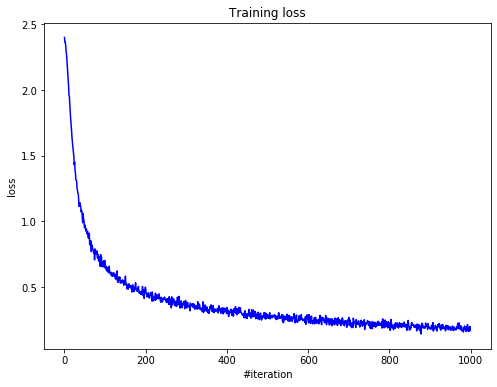

In [149]:
%time
n_epochs = 20
batch_size = 1000

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_history = []
model.train(True)

for i in range(n_epochs):
    for X_batch, y_batch in get_batches((torch.FloatTensor(X_train), torch.Tensor(y_train)), batch_size):
        
        optimizer.zero_grad()
        
        predictions = model.forward(X_batch)
        loss = criterion(predictions, torch.max(y_batch, 1)[1])
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss)
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("iteration num")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

In [152]:
model.eval()
answers, labels = [], []
with torch.no_grad():
    for X_batch, y_batch in get_batches((X_test, torch.Tensor(y_test)), batch_size):
        predictions = model.forward(torch.FloatTensor(X_batch))
        prediction = predictions.argmax(axis=1).reshape(-1, 1)
        answers.append(prediction)
        labels.append(y_batch.reshape(-1, 1))

answers = np.vstack(answers)
labels = np.vstack(labels)

In [153]:
from sklearn.metrics import accuracy_score
print(accuracy_score(answers, labels))

0.9525


Скорость у реализации на torch выше, точность результатов получилась примерно одинаковой